In [72]:
import main
import os

import numpy as np
import cv2

import math

image array:
 [[197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 ...
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]
 [197 197 197 ... 197 197 197]]
num images loaded: 10


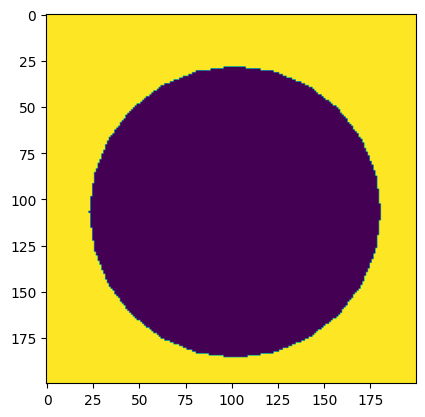

In [73]:
base_path = os.getcwd()

img_path = os.path.join(base_path, "data", "geometric shapes dataset", "Circle", "Circle_0a0b51ca-2a86-11ea-8123-8363a7ec19e6.png")

# cv2.imread does not work on linux, im using matlab for visualization
img_BGR = main.load_img(img_path, greyscale=False)
img = main.load_img(img_path)
print("image array:\n", img)
main.plt.imshow(img)

folder_path = os.path.join(base_path, 'data', 'geometric shapes dataset', 'Square')
data = main.load_img_from_folder(folder_path)
print("num images loaded:", len(data))


image shape: (200, 200)
lines detected:
[]


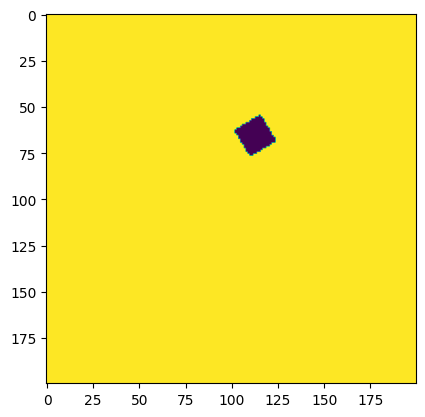

In [74]:
img = data[0]
print("image shape:", img.shape)
main.plt.imshow(img)
lines = main.detect_line(img, canny_thres1=10, 
             canny_thres2=150, 
             rho=1, 
             theta=main.np.pi/180, 
             hough_thres=80, 
             min_line_len=30, 
             max_line_gap=10)
print("lines detected:")
print(lines)

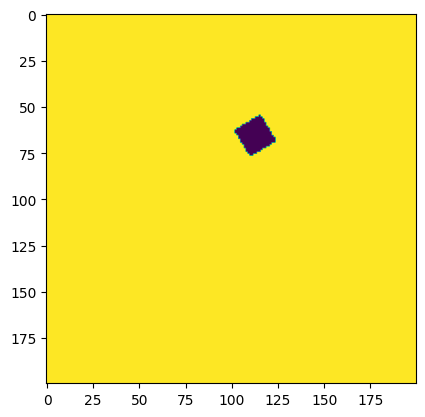

In [75]:
out = main.draw_lines(img, lines)
main.plt.imshow(out)

**Test Edge Detection on Shapes**

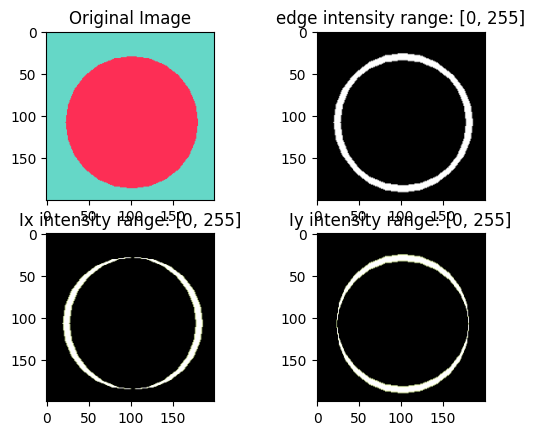

In [76]:
edges, Ix, Iy = main.detect_edges(img_BGR, derv_len=5)

def show_edge_results(img, edges, Ix, Iy):

    def get_minmax(img):
        min = np.min(img)
        max = np.max(img)
        return min, max

    fig, ax = main.plt.subplots(2,2)
    ax[0,0].title.set_text("Original Image")
    ax[0,0].imshow(img)

    min, max = get_minmax(edges)
    ax[0,1].title.set_text(f"edge intensity range: [{min}, {max}]")
    ax[0,1].imshow(edges, cmap='gray', vmin=min, vmax=max)

    min, max = get_minmax(Ix)
    ax[1,0].title.set_text(f"Ix intensity range: [{min}, {max}]")
    ax[1,0].imshow(Ix, vmin=min, vmax=max)

    min, max = get_minmax(Iy)
    ax[1,1].title.set_text(f"Iy intensity range: [{min}, {max}]")
    ax[1,1].imshow(Iy, vmin=min, vmax=max)

show_edge_results(img_BGR, edges, Ix, Iy)

**Test Edge Detection on Physical Parts**

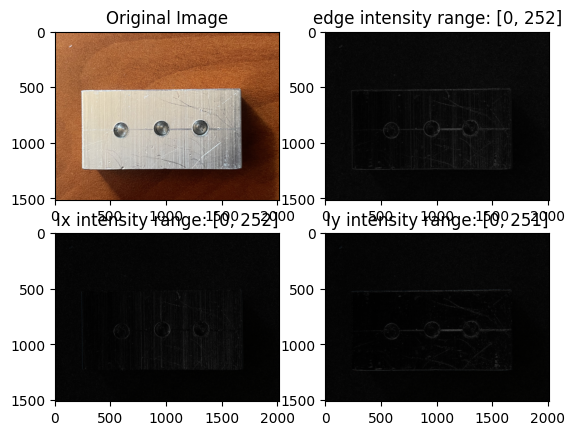

In [77]:
img_path = os.path.join(base_path, "data", "physical parts", "Basic II base part.jpg")

img_part1 = main.load_img(img_path, greyscale=False)
# crop img
H,W = img_part1.shape[0:2]
Z = 4   # zoom factor
Zh = Z//2
img_part1 = img_part1[H*(Zh-1)//Z : H*(Zh+1)//Z , W*(Zh-1)//Z : W*(Zh+1)//Z]
# convert to RGB
img_part1 = main.cv2.cvtColor(img_part1, main.cv2.COLOR_BGR2RGB)

edges, Ix, Iy = main.detect_edges(img_part1, derv_len=1)

show_edge_results(img_part1, edges, Ix, Iy)

**Test edge detection with denoising**

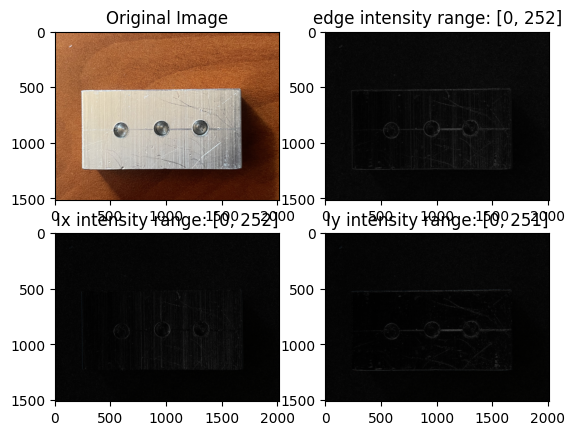

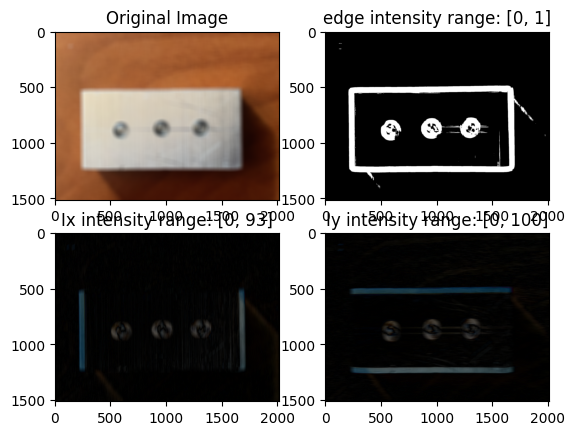

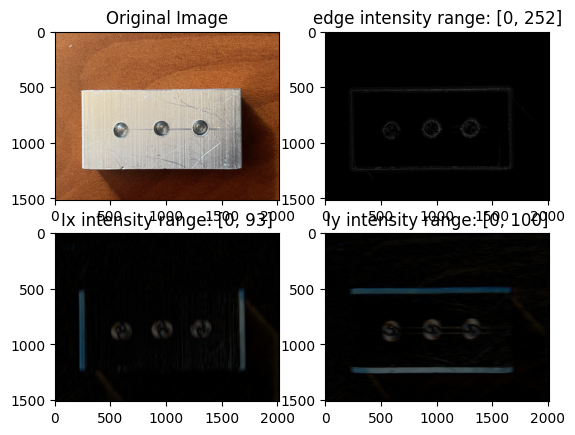

In [78]:
# get fine edges (org image, 1-step gradient)
edges_fine, Ix, Iy = main.detect_edges(img_part1, derv_len=1)
show_edge_results(img_part1, edges_fine, Ix, Iy)

# gauss blur img
sigma = 50
img_part1_gb = cv2.GaussianBlur(img_part1, ksize=(sigma+1,sigma+1), sigmaX=sigma, sigmaY=sigma)
# take large-step gradient
step = sigma//10
step = step if step>0 else 1
edges_crude, Ix, Iy = main.detect_edges(img_part1_gb, derv_len=sigma//10)
# threshold
thrs = 90   # percentile above which to keep
edges_crude = np.where(edges_crude>=np.percentile(edges_crude, thrs), 1, 0)
show_edge_results(img_part1_gb, edges_crude, Ix, Iy)
# mask
edges_masked = np.where(edges_crude>0, edges_fine, 0)
show_edge_results(img_part1, edges_masked, Ix, Iy)


# Run Hough Transform

TODO: Canny may not be necessary with our own edge detector

In [98]:
def showImage(image, ttl="Image"):
    main.plt.title(ttl)
    main.plt.imshow(image)
    main.plt.axis('off')
    main.plt.show()

def applyHoughTransform(image):
    if image.ndim == 3:
        img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        base_for_drawing = image.copy()
    else:
        img_gray = image
        base_for_drawing = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    lines = main.detect_line(
        img_gray,
        canny_thres1=100,
        canny_thres2=200,
        rho=1,
        theta=main.np.pi/180,
        hough_thres=180,
        min_line_len=200,
        max_line_gap=15,
    )

    img_with_lines = main.draw_lines(base_for_drawing, lines, color=(0, 0, 255), thickness=2)
    img_rgb = cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB)
    return img_rgb


def applyGradient(image):
    sigma = 30
    thrs = 97
    img_part1_gb = cv2.GaussianBlur(image, ksize=(sigma+1, sigma+1), sigmaX=sigma, sigmaY=sigma)
    edges_crude, Ix, Iy = main.detect_edges(img_part1_gb, derv_len=sigma//10)
    edges_crude = np.where(edges_crude >= np.percentile(edges_crude, thrs), 255, 0).astype("uint8")
    return edges_crude

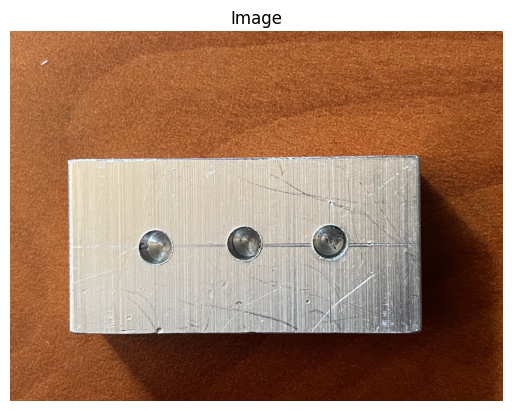

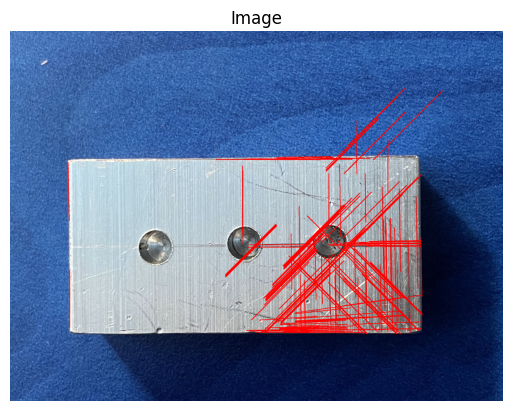

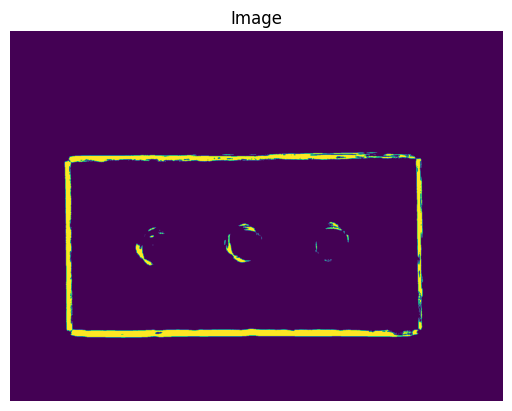

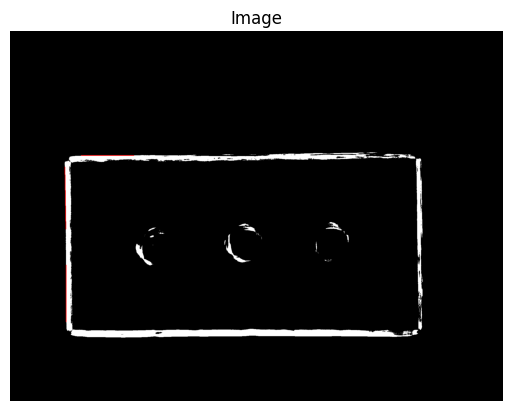

In [99]:

showImage(img_part1)


houghOutput = applyHoughTransform(img_part1)
showImage(houghOutput)



gradient = applyGradient(img_part1)
showImage(gradient)

gradient_hough = applyHoughTransform(gradient)
showImage(gradient_hough)



**Run Hough Transform with masked edges and tune parameters**

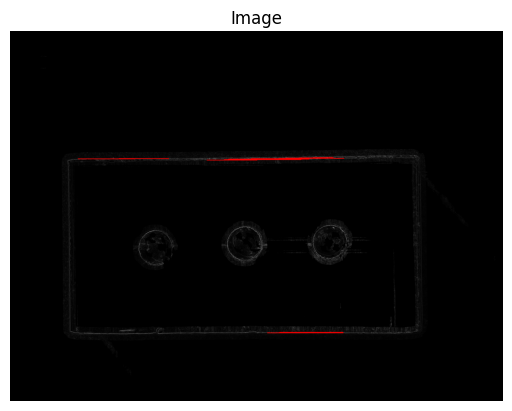

In [81]:
houghOutput = applyHoughTransform(edges_masked)
showImage(houghOutput)

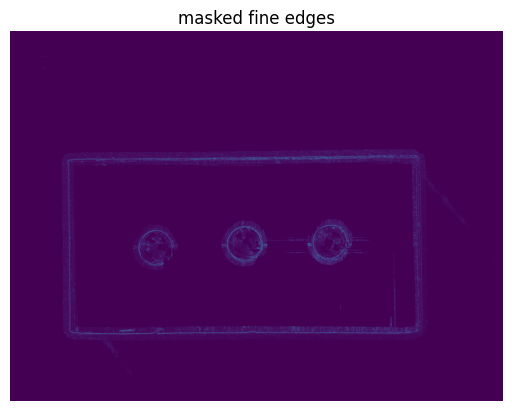

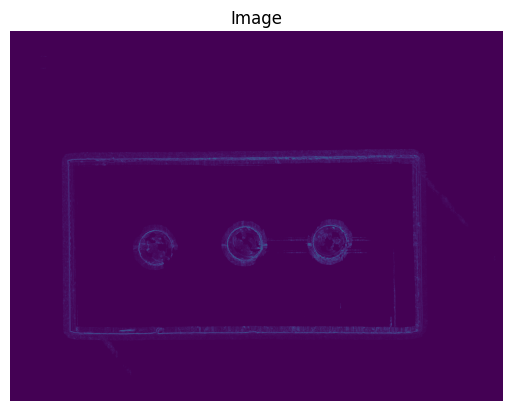

found 321 lines


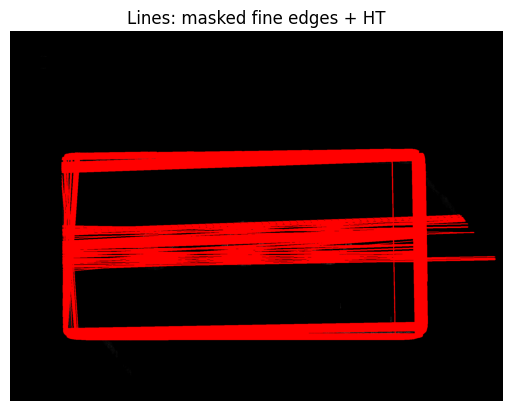

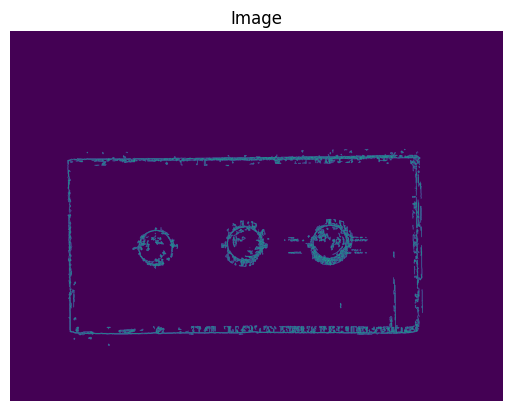

found 44 lines


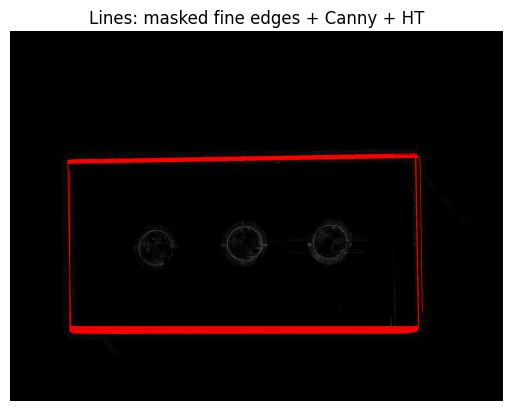

In [101]:
input = edges_masked
# input = edges_fine
showImage(input, ttl="masked fine edges")
# DEFINE HT PARAMS

# DEFINE TEST FUNCTION
def find_lines(input, canny=False, probabilistic=True):
    img = input.copy()

    # find edges using Canny
    if canny:
        img = cv2.Canny(img, 50, 150)
    showImage(img)

    # detect lines using Hough Transform
    rho = 1
    theta = np.pi/180
    threshold = 200
    if probabilistic:
        lines = cv2.HoughLinesP(img, rho = rho, theta = theta, threshold = threshold,
                                minLineLength = 10,
                                maxLineGap = 1e6)
        lines = [tuple(line[0]) for line in lines]
    else:
        lns = cv2.HoughLines(img, rho = rho, theta = theta, threshold=threshold,
                               srn=0,
                               stn=0)
        lines = []
        for i in range(0, len(lns)):
            rho = lns[i][0][0]
            theta = lns[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            lines.append( (int(x0 + 1000*(-b)), int(y0 + 1000*(a)), int(x0 - 1000*(-b)), int(y0 - 1000*(a))) )

    print(f"found {len(lines)} lines")

    # draw lines
    base = cv2.cvtColor(input, cv2.COLOR_GRAY2BGR)
    input_n_lines = main.draw_lines(base, lines)
    return cv2.cvtColor(input_n_lines, cv2.COLOR_BGR2RGB)


# APPROACH 1: apply HT directly to masked fine edges
found_lines_HT = find_lines(input)
showImage(found_lines_HT, ttl="Lines: masked fine edges + HT")


# APPROACH 2: masked fine edges + Canny + HT
found_lines_canny_HT = find_lines(input, canny=True)
showImage(found_lines_canny_HT, ttl="Lines: masked fine edges + Canny + HT")

# APPROACH 3: first: org + FT + FLP -> LPF edges; then: LPF edge + Canny + HT
 


*General Insights in using HoughLinesP:*
* Set maxLineGap to a large number to pick up long & continuous single lines
* Increase threshold to filter out short noisy lines
* Try not to set minLineLength too high, or actual features that are a bit short might be falsely ignored